In [18]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%autoreload 2

import os, argparse, json, copy, wandb

import umap
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from dataset_utils import *
from utils import HiddenPrints
import torch.fft as fft
from einops import rearrange, repeat

import pandas as pd
import numpy as np
from termcolor import cprint
from pprint import pprint
from tqdm import tqdm
from datetime import datetime

from train import finetune

from trainer import Trainer, model_finetune, model_test, model_pretrain
from train import evaluate

from augmentations import *
from dataloader import MIdatasetMC
from config_files.BIG_EEG_MI_1chRearrange_bigger import Config as Configs
from utils import _logger, set_requires_grad
from model import *
from utils import _calc_metrics, copy_Files
from loss import * # base_Model, base_Model_F, target_classifier
from sklearn.metrics import cohen_kappa_score as kappa



# For Arial
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams["text.usetex"] = False

# for latex:
# matplotlib.rcParams['font.family'] = "DejaVu Sans"
# matplotlib.rcParams['font.serif'] = "Computer Modern"
# matplotlib.rcParams["text.usetex"] = True

matplotlib.rcParams["lines.linewidth"] = 3
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["axes.labelsize"] = 22
matplotlib.rcParams["xtick.labelsize"] = 22
matplotlib.rcParams["ytick.labelsize"] = 22
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams["legend.fontsize"] = 22
matplotlib.rcParams["axes.titlesize"] = 22
matplotlib.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams["figure.autolayout"] = True

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'

print(f'CUDA available: {torch.cuda.is_available()}')
cprint(torch.__version__, color='green')
device_count = torch.cuda.device_count()
for i in range(device_count):
    torch.cuda.set_device(i)
    cur_device_id = torch.cuda.current_device()
    cur_device_name = torch.cuda.get_device_name(cur_device_id)
    print(f'Current device:\nID {cur_device_id} | Name: {cur_device_name}')
    print(f'supported arch list: {torch.cuda.get_arch_list()}\n')
    

CUDA available: True
1.12.1+cu113
Current device:
ID 0 | Name: RTX A6000
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Current device:
ID 1 | Name: Quadro P2200
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']



In [20]:
device = 'cuda:0'
configs = Configs()
# configs.report()

In [21]:
# load the data and instantiate the Dataset class

path = '/home/roman/CODE/tachikoma-analysis/DATA2'
dataset = torch.load(os.path.join(path, "BIG_MI_12_datasets_53213samp.pt"))
dataset['info']

"Srate = 100 Hz, passband: 0-45 Hz, channels ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']. See meta for more details. See /home/roman/CODE/tachikoma-analysis/DATA"

In [22]:
shuffle = False
targetDsName = 'BNCIPhysionetMotorImagery.pt'
test_subject = 2



pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
train_dataset, test_dataset = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=test_subject)
# train_dataset, test_dataset = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=None)

Nsubj = len(train_dataset['meta'].subject.unique())
cprint(f"Number of subjects in train_dataset: {Nsubj}", color='blue')
print(dataset['meta'].ds.unique())

BNCIPhysionetMotorImagery.pt
pretrain_dataset: torch.Size([48295])
['right_hand' 'left_hand']
target_dataset: torch.Size([4918])
Total samples in pretrain and finetune: 53213
test_subject: 2
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
Number of subjects in train_dataset: 108
['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']


In [23]:
test_dataset['meta']

,subject,session,run,label,ds,class_id
30781,2,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30782,2,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30783,2,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30784,2,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30785,2,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30786,2,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30787,2,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30788,2,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30789,2,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30790,2,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1


<AxesSubplot:>

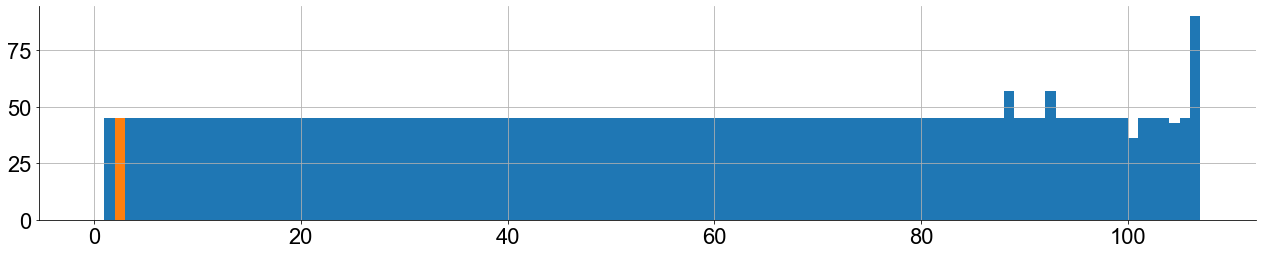

In [24]:
fig, ax = plt.subplots(1,1, figsize=(18,4))
train_dataset['meta'].subject.hist(ax=ax, bins=range(0,Nsubj), label='train')
test_dataset['meta'].subject.hist(ax=ax, bins=range(0,Nsubj), label='test')

In [26]:
EEGnet = TorchEEGNet(num_chan=7, kerLen=31, drop=0.5, F1=8, D=2, F2=16, nclass=2, device=device)
EEGnet.summary(num_time_samples=120)

******************************************************************************************
For 120 time samples, the network will look like this:
------------------------------------------------------------------------------------------
Conv2d(1, 8, kernel_size=(1, 31), stride=(1, 1), padding=same, bias=False)
------------------------------------------------------------------------------------------
Input: torch.Size([10, 1, 7, 120])
weight, torch.Size([8, 1, 1, 31]), Nparams: 248
Output: torch.Size([10, 8, 7, 120])

------------------------------------------------------------------------------------------
BatchNorm2d(8, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
------------------------------------------------------------------------------------------
Input: torch.Size([10, 8, 7, 120])
weight, torch.Size([8]), Nparams: 8
bias, torch.Size([8]), Nparams: 8
Output: torch.Size([10, 8, 7, 120])

--------------------------------------------------------------------------

/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [16]:
def EEGNet_run(train_dataset, test_dataset):
    
    nclass = len(test_dataset['meta'].class_id.unique())
    cprint(f'number of classes: {nclass}', 'red')
    
    EEGnet = TorchEEGNet(num_chan=7, kerLen=31, drop=0.5, F1=8, D=2, F2=16, nclass=nclass, device=device)
    # EEGnet.summary(num_time_samples=120)

    # instantiate the Dataset class
    ds = MIdatasetMC(train_dataset, configs)

    # instantiate a dataloader for the fine-tuning dataset
    dl = torch.utils.data.DataLoader(dataset=ds,
                                              batch_size=configs.batch_size,
                                              shuffle=True,
                                              drop_last=True,
                                              num_workers=14)  # optimal: 14 workers with batch_size=60

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=EEGnet.model.parameters(), lr=0.003)
    
    EVAL_ACC = []
    evalAcc = 0
    for ep in range(10):
        epAcc = []
        pbar = tqdm(enumerate(dl))

        EEGnet.model.train()
        for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in pbar:

            x_t, y = x_t.float().unsqueeze(1).to(device), y.long().to(device)
            # x_t_aug = x_t_aug.float().to(device)
            # x_f, x_f_aug = x_f.float().to(device), x_f_aug.float().to(device)

            optimizer.zero_grad()
            pred = EEGnet.forward(x_t)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            EEGnet.max_norm()
            withinBatchAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
            epAcc.append(withinBatchAcc)
            pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')

        # evaluate:
        EEGnet.model.eval()
        x_t = test_dataset['samples'].unsqueeze(1).float().to(device)
        y = test_dataset['labels']
        pred = EEGnet.forward(x_t)
        evalAcc = np.mean([(p == l) for p, l in zip(pred.argmax(axis=1).tolist(), y.tolist())])
        pbar.set_description(f'epoch_acc: {np.mean(epAcc):.2f} evalAcc: {evalAcc:.2f} batch_acc: {withinBatchAcc:.2f}')
        EVAL_ACC.append(evalAcc)
    return np.max(EVAL_ACC), np.mean(epAcc)


EEGNet_run(train_dataset, test_dataset)

number of classes: 2
torch.Size([4873, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 64.78it/s]
epoch_acc: 0.68 evalAcc: 0.87 batch_acc: 0.66: : 50it [00:00, 62.17it/s]
epoch_acc: 0.72 evalAcc: 0.91 batch_acc: 0.68: : 50it [00:00, 60.90it/s]
epoch_acc: 0.73 evalAcc: 0.87 batch_acc: 0.75: : 50it [00:00, 60.72it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.75: : 50it [00:00, 68.73it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.79: : 50it [00:00, 63.09it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.75: : 50it [00:00, 67.59it/s]
epoch_acc: 0.75 evalAcc: 0.93 batch_acc: 0.83: : 50it [00:00, 59.45it/s]
epoch_acc: 0.75 evalAcc: 0.96 batch_acc: 0.75: : 50it [00:00, 63.05it/s]
epoch_acc: 0.75 evalAcc: 0.96 batch_acc: 0.77: : 50it [00:00, 60.18it/s]


(0.9555555555555556, 0.7491666666666668)

# Cross-subject validation

In [10]:
R = []
for i in target_dataset['meta'].subject.unique().tolist():
    train_dataset, test_dataset = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=i)
    max_val_acc, lastEpTrainAcc = EEGNet_run(train_dataset, test_dataset)
    R.append({'test_subject': i,
              'max_test_acc': max_val_acc, 
              'lastEpTrainAcc': lastEpTrainAcc})
    

test_subject: 1
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.59: : 50it [00:00, 52.34it/s]
epoch_acc: 0.70 evalAcc: 0.58 batch_acc: 0.76: : 50it [00:00, 57.24it/s]
epoch_acc: 0.72 evalAcc: 0.62 batch_acc: 0.74: : 50it [00:00, 59.16it/s]
epoch_acc: 0.73 evalAcc: 0.62 batch_acc: 0.72: : 50it [00:00, 58.02it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.73: : 50it [00:00, 57.75it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.73: : 50it [00:00, 60.95it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.77: : 50it [00:00, 59.81it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.75: : 50it [00:00, 59.90it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.72: : 50it [00:00, 66.13it/s]
epoch_acc: 0.75 evalAcc: 0.76 batch_acc: 0.71: : 50it [00:00, 63.79it/s]


test_subject: 2
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.55 evalAcc: 0.00 batch_acc: 0.60: : 50it [00:00, 63.00it/s]
epoch_acc: 0.68 evalAcc: 0.71 batch_acc: 0.72: : 50it [00:00, 59.89it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.72: : 50it [00:00, 58.42it/s]
epoch_acc: 0.73 evalAcc: 0.91 batch_acc: 0.74: : 50it [00:00, 64.34it/s]
epoch_acc: 0.73 evalAcc: 0.87 batch_acc: 0.67: : 50it [00:00, 60.79it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.74: : 50it [00:00, 57.04it/s]
epoch_acc: 0.75 evalAcc: 0.93 batch_acc: 0.74: : 50it [00:00, 60.07it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.76: : 50it [00:00, 62.20it/s]
epoch_acc: 0.75 evalAcc: 0.89 batch_acc: 0.67: : 50it [00:00, 54.88it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.71: : 50it [00:00, 60.26it/s]


test_subject: 3
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.79: : 50it [00:00, 59.71it/s]
epoch_acc: 0.72 evalAcc: 0.96 batch_acc: 0.72: : 50it [00:00, 61.28it/s]
epoch_acc: 0.73 evalAcc: 0.93 batch_acc: 0.72: : 50it [00:00, 58.46it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.75: : 50it [00:00, 59.02it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.85: : 50it [00:00, 59.99it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.70: : 50it [00:00, 60.17it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.77: : 50it [00:00, 58.87it/s]
epoch_acc: 0.75 evalAcc: 0.96 batch_acc: 0.73: : 50it [00:00, 60.94it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.77: : 50it [00:00, 66.76it/s]
epoch_acc: 0.75 evalAcc: 0.93 batch_acc: 0.76: : 50it [00:00, 58.36it/s]


test_subject: 4
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.64: : 50it [00:00, 60.76it/s]
epoch_acc: 0.70 evalAcc: 0.73 batch_acc: 0.69: : 50it [00:00, 60.99it/s]
epoch_acc: 0.73 evalAcc: 0.84 batch_acc: 0.67: : 50it [00:00, 60.82it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.75: : 50it [00:00, 59.76it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.81: : 50it [00:00, 61.01it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.73: : 50it [00:00, 62.40it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.76: : 50it [00:00, 61.16it/s]
epoch_acc: 0.75 evalAcc: 0.82 batch_acc: 0.71: : 50it [00:00, 64.68it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.75: : 50it [00:00, 56.25it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.67: : 50it [00:00, 59.95it/s]


test_subject: 5
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.62: : 50it [00:00, 60.40it/s]
epoch_acc: 0.70 evalAcc: 0.53 batch_acc: 0.75: : 50it [00:00, 61.62it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.73: : 50it [00:00, 59.91it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.72: : 50it [00:00, 57.16it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.69: : 50it [00:00, 59.11it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.84: : 50it [00:00, 57.27it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.79: : 50it [00:00, 60.88it/s]
epoch_acc: 0.74 evalAcc: 0.56 batch_acc: 0.72: : 50it [00:00, 62.05it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.73: : 50it [00:00, 58.71it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.77: : 50it [00:00, 61.90it/s]


test_subject: 6
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.75: : 50it [00:00, 62.05it/s]
epoch_acc: 0.69 evalAcc: 0.84 batch_acc: 0.75: : 50it [00:00, 55.51it/s]
epoch_acc: 0.72 evalAcc: 0.91 batch_acc: 0.67: : 50it [00:00, 55.52it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.70: : 50it [00:00, 60.23it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.73: : 50it [00:00, 60.68it/s]
epoch_acc: 0.73 evalAcc: 0.91 batch_acc: 0.74: : 50it [00:00, 62.25it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.72: : 50it [00:00, 63.20it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.69: : 50it [00:00, 58.80it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.75: : 50it [00:00, 60.58it/s]
epoch_acc: 0.75 evalAcc: 0.84 batch_acc: 0.76: : 50it [00:00, 62.93it/s]


test_subject: 7
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.77: : 50it [00:00, 58.95it/s]
epoch_acc: 0.71 evalAcc: 0.73 batch_acc: 0.81: : 50it [00:00, 59.82it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.68: : 50it [00:00, 60.32it/s]
epoch_acc: 0.74 evalAcc: 0.53 batch_acc: 0.72: : 50it [00:00, 58.36it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.81: : 50it [00:00, 58.24it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.77: : 50it [00:00, 57.85it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.76: : 50it [00:00, 63.22it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.75: : 50it [00:00, 60.42it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.83: : 50it [00:00, 63.36it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.70: : 50it [00:00, 60.76it/s]


test_subject: 8
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.58: : 50it [00:00, 63.91it/s]
epoch_acc: 0.68 evalAcc: 0.64 batch_acc: 0.71: : 50it [00:00, 57.59it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.71: : 50it [00:00, 65.98it/s] 
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.77: : 50it [00:00, 58.23it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.79: : 50it [00:00, 61.00it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.76: : 50it [00:00, 59.51it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.68: : 50it [00:00, 60.83it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.80: : 50it [00:00, 57.58it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.75: : 50it [00:00, 59.22it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.78: : 50it [00:00, 63.64it/s]


test_subject: 9
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.70: : 50it [00:00, 61.54it/s]
epoch_acc: 0.72 evalAcc: 0.80 batch_acc: 0.71: : 50it [00:00, 57.68it/s]
epoch_acc: 0.73 evalAcc: 0.82 batch_acc: 0.69: : 50it [00:00, 59.90it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.74: : 50it [00:00, 57.55it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.76: : 50it [00:00, 58.76it/s]
epoch_acc: 0.75 evalAcc: 0.82 batch_acc: 0.73: : 50it [00:00, 60.26it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.76: : 50it [00:00, 58.83it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.75: : 50it [00:00, 58.75it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.71: : 50it [00:00, 58.72it/s]
epoch_acc: 0.75 evalAcc: 0.84 batch_acc: 0.71: : 50it [00:00, 54.89it/s]


test_subject: 10
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.70: : 50it [00:00, 63.52it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.75: : 50it [00:00, 59.02it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.77: : 50it [00:00, 58.34it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.69: : 50it [00:00, 56.76it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.78: : 50it [00:00, 59.83it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.74: : 50it [00:00, 62.37it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.75: : 50it [00:00, 60.44it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.71: : 50it [00:00, 59.19it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.72: : 50it [00:00, 66.28it/s]
epoch_acc: 0.76 evalAcc: 0.67 batch_acc: 0.81: : 50it [00:00, 58.10it/s]


test_subject: 11
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 62.53it/s]
epoch_acc: 0.72 evalAcc: 0.82 batch_acc: 0.78: : 50it [00:00, 61.28it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.67: : 50it [00:00, 61.04it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.73: : 50it [00:00, 61.07it/s]
epoch_acc: 0.75 evalAcc: 0.84 batch_acc: 0.74: : 50it [00:00, 61.33it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.73: : 50it [00:00, 59.80it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.79: : 50it [00:00, 60.24it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.85: : 50it [00:00, 62.64it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.70: : 50it [00:00, 59.21it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.83: : 50it [00:00, 65.17it/s]


test_subject: 12
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.65: : 50it [00:00, 62.36it/s]
epoch_acc: 0.72 evalAcc: 0.73 batch_acc: 0.76: : 50it [00:00, 60.52it/s]
epoch_acc: 0.73 evalAcc: 0.80 batch_acc: 0.74: : 50it [00:00, 58.31it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.78: : 50it [00:00, 58.02it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.74: : 50it [00:00, 61.57it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.77: : 50it [00:00, 57.68it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.71: : 50it [00:00, 54.62it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.81: : 50it [00:00, 60.23it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.77: : 50it [00:00, 59.28it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.72: : 50it [00:00, 62.83it/s]


test_subject: 13
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.54: : 50it [00:00, 60.43it/s]
epoch_acc: 0.70 evalAcc: 0.62 batch_acc: 0.75: : 50it [00:00, 60.83it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.79: : 50it [00:00, 60.04it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.72: : 50it [00:00, 61.64it/s]
epoch_acc: 0.73 evalAcc: 0.62 batch_acc: 0.82: : 50it [00:00, 57.89it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.69: : 50it [00:00, 57.50it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.71: : 50it [00:00, 59.27it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.77: : 50it [00:00, 61.20it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.74: : 50it [00:00, 58.75it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.77: : 50it [00:00, 58.00it/s]


test_subject: 14
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.66: : 50it [00:00, 62.67it/s]
epoch_acc: 0.72 evalAcc: 0.62 batch_acc: 0.70: : 50it [00:00, 59.78it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.76: : 50it [00:00, 60.71it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.75: : 50it [00:00, 62.79it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.74: : 50it [00:00, 59.77it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.69: : 50it [00:00, 58.42it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.69: : 50it [00:00, 55.64it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.77: : 50it [00:00, 60.08it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.77: : 50it [00:00, 57.93it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.78: : 50it [00:00, 56.40it/s]


test_subject: 15
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.72: : 50it [00:00, 59.52it/s]
epoch_acc: 0.69 evalAcc: 0.80 batch_acc: 0.67: : 50it [00:00, 60.79it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.81: : 50it [00:00, 59.73it/s]
epoch_acc: 0.73 evalAcc: 0.98 batch_acc: 0.68: : 50it [00:00, 59.42it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.74: : 50it [00:00, 62.99it/s]
epoch_acc: 0.75 evalAcc: 0.96 batch_acc: 0.71: : 50it [00:00, 61.25it/s]
epoch_acc: 0.74 evalAcc: 0.96 batch_acc: 0.76: : 50it [00:00, 59.85it/s]
epoch_acc: 0.75 evalAcc: 0.96 batch_acc: 0.78: : 50it [00:00, 58.28it/s]
epoch_acc: 0.74 evalAcc: 0.96 batch_acc: 0.73: : 50it [00:00, 59.56it/s]
epoch_acc: 0.75 evalAcc: 0.93 batch_acc: 0.77: : 50it [00:00, 59.12it/s]


test_subject: 16
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 62.24it/s]
epoch_acc: 0.71 evalAcc: 0.62 batch_acc: 0.71: : 50it [00:00, 57.92it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.72: : 50it [00:00, 64.08it/s]
epoch_acc: 0.72 evalAcc: 0.67 batch_acc: 0.68: : 50it [00:00, 61.09it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.76: : 50it [00:00, 63.35it/s]
epoch_acc: 0.73 evalAcc: 0.62 batch_acc: 0.75: : 50it [00:00, 64.05it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.73: : 50it [00:00, 61.79it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.73: : 50it [00:00, 62.42it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.77: : 50it [00:00, 56.42it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.75: : 50it [00:00, 60.54it/s]


test_subject: 17
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.62: : 50it [00:00, 58.65it/s]
epoch_acc: 0.70 evalAcc: 0.76 batch_acc: 0.69: : 50it [00:00, 60.43it/s]
epoch_acc: 0.72 evalAcc: 0.78 batch_acc: 0.71: : 50it [00:00, 61.17it/s]
epoch_acc: 0.73 evalAcc: 0.80 batch_acc: 0.79: : 50it [00:00, 59.69it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.68: : 50it [00:00, 58.88it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.68: : 50it [00:00, 60.76it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.69: : 50it [00:00, 62.77it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.68: : 50it [00:00, 60.87it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.71: : 50it [00:00, 62.35it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.76: : 50it [00:00, 60.30it/s]


test_subject: 18
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.56 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 60.34it/s]
epoch_acc: 0.71 evalAcc: 0.96 batch_acc: 0.73: : 50it [00:00, 57.65it/s]
epoch_acc: 0.73 evalAcc: 0.98 batch_acc: 0.76: : 50it [00:00, 61.91it/s]
epoch_acc: 0.73 evalAcc: 0.98 batch_acc: 0.70: : 50it [00:00, 63.44it/s]
epoch_acc: 0.73 evalAcc: 0.98 batch_acc: 0.72: : 50it [00:00, 55.15it/s]
epoch_acc: 0.74 evalAcc: 0.98 batch_acc: 0.77: : 50it [00:00, 61.32it/s]
epoch_acc: 0.74 evalAcc: 0.98 batch_acc: 0.81: : 50it [00:00, 59.08it/s]
epoch_acc: 0.73 evalAcc: 0.96 batch_acc: 0.71: : 50it [00:00, 60.06it/s]
epoch_acc: 0.74 evalAcc: 0.98 batch_acc: 0.67: : 50it [00:00, 54.65it/s]
epoch_acc: 0.74 evalAcc: 0.98 batch_acc: 0.74: : 50it [00:00, 59.77it/s]


test_subject: 19
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.78: : 50it [00:00, 66.57it/s]
epoch_acc: 0.71 evalAcc: 0.71 batch_acc: 0.74: : 50it [00:00, 62.67it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.71: : 50it [00:00, 59.15it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.79: : 50it [00:00, 59.64it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.65: : 50it [00:00, 60.35it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.75: : 50it [00:00, 58.29it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.71: : 50it [00:00, 56.84it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.71: : 50it [00:00, 58.21it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.74: : 50it [00:00, 59.57it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.74: : 50it [00:00, 62.75it/s]


test_subject: 20
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.65: : 50it [00:00, 57.66it/s]
epoch_acc: 0.70 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 61.08it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.73: : 50it [00:00, 63.35it/s]
epoch_acc: 0.73 evalAcc: 0.80 batch_acc: 0.72: : 50it [00:00, 63.68it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.71: : 50it [00:00, 61.02it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.77: : 50it [00:00, 64.02it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.70: : 50it [00:00, 62.14it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.68: : 50it [00:00, 59.19it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.69: : 50it [00:00, 58.86it/s]
epoch_acc: 0.75 evalAcc: 0.82 batch_acc: 0.76: : 50it [00:00, 59.69it/s]


test_subject: 21
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.72: : 50it [00:00, 59.40it/s]
epoch_acc: 0.71 evalAcc: 0.71 batch_acc: 0.72: : 50it [00:00, 57.21it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.82: : 50it [00:00, 59.94it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.67: : 50it [00:00, 59.14it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.74: : 50it [00:00, 58.43it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.66: : 50it [00:00, 58.11it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.73: : 50it [00:00, 58.52it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.78: : 50it [00:00, 57.43it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.78: : 50it [00:00, 56.49it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.78: : 50it [00:00, 57.84it/s]


test_subject: 22
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.58 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 62.16it/s]
epoch_acc: 0.69 evalAcc: 0.96 batch_acc: 0.79: : 50it [00:00, 61.84it/s]
epoch_acc: 0.73 evalAcc: 0.98 batch_acc: 0.67: : 50it [00:00, 60.66it/s]
epoch_acc: 0.72 evalAcc: 1.00 batch_acc: 0.76: : 50it [00:00, 63.04it/s]
epoch_acc: 0.74 evalAcc: 1.00 batch_acc: 0.78: : 50it [00:00, 56.44it/s]
epoch_acc: 0.73 evalAcc: 1.00 batch_acc: 0.81: : 50it [00:00, 60.51it/s]
epoch_acc: 0.74 evalAcc: 1.00 batch_acc: 0.74: : 50it [00:00, 62.95it/s]
epoch_acc: 0.74 evalAcc: 1.00 batch_acc: 0.76: : 50it [00:00, 60.60it/s]
epoch_acc: 0.74 evalAcc: 1.00 batch_acc: 0.71: : 50it [00:00, 57.21it/s]
epoch_acc: 0.74 evalAcc: 1.00 batch_acc: 0.70: : 50it [00:00, 61.62it/s]


test_subject: 23
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.58 evalAcc: 0.00 batch_acc: 0.65: : 50it [00:00, 59.74it/s]
epoch_acc: 0.69 evalAcc: 0.67 batch_acc: 0.76: : 50it [00:00, 57.36it/s]
epoch_acc: 0.72 evalAcc: 0.76 batch_acc: 0.78: : 50it [00:00, 55.63it/s]
epoch_acc: 0.73 evalAcc: 0.73 batch_acc: 0.73: : 50it [00:00, 61.75it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.70: : 50it [00:00, 59.58it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.74: : 50it [00:00, 61.26it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.76: : 50it [00:00, 62.22it/s]
epoch_acc: 0.75 evalAcc: 0.84 batch_acc: 0.78: : 50it [00:00, 64.93it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.77: : 50it [00:00, 60.52it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.77: : 50it [00:00, 66.66it/s]


test_subject: 24
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.72: : 50it [00:00, 58.11it/s]
epoch_acc: 0.72 evalAcc: 0.69 batch_acc: 0.79: : 50it [00:00, 64.71it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.76: : 50it [00:00, 62.24it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.79: : 50it [00:00, 60.55it/s]
epoch_acc: 0.73 evalAcc: 0.80 batch_acc: 0.70: : 50it [00:00, 58.59it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.84: : 50it [00:00, 58.12it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.71: : 50it [00:00, 63.03it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.73: : 50it [00:00, 56.10it/s]
epoch_acc: 0.76 evalAcc: 0.78 batch_acc: 0.70: : 50it [00:00, 60.28it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.76: : 50it [00:00, 55.81it/s]


test_subject: 25
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.70: : 50it [00:00, 57.76it/s]
epoch_acc: 0.72 evalAcc: 0.38 batch_acc: 0.73: : 50it [00:00, 61.11it/s]
epoch_acc: 0.73 evalAcc: 0.44 batch_acc: 0.76: : 50it [00:00, 61.87it/s]
epoch_acc: 0.74 evalAcc: 0.47 batch_acc: 0.70: : 50it [00:00, 64.73it/s]
epoch_acc: 0.74 evalAcc: 0.51 batch_acc: 0.79: : 50it [00:00, 58.45it/s]
epoch_acc: 0.75 evalAcc: 0.44 batch_acc: 0.77: : 50it [00:00, 60.77it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.74: : 50it [00:00, 64.76it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.71: : 50it [00:00, 60.38it/s]
epoch_acc: 0.75 evalAcc: 0.47 batch_acc: 0.77: : 50it [00:00, 55.98it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.74: : 50it [00:00, 60.17it/s]


test_subject: 26
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 65.65it/s]
epoch_acc: 0.71 evalAcc: 0.62 batch_acc: 0.73: : 50it [00:00, 60.89it/s]
epoch_acc: 0.73 evalAcc: 0.60 batch_acc: 0.80: : 50it [00:00, 59.19it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.74: : 50it [00:00, 58.72it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.75: : 50it [00:00, 62.94it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.81: : 50it [00:00, 60.18it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.74: : 50it [00:00, 58.57it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.73: : 50it [00:00, 60.57it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.74: : 50it [00:00, 58.63it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.74: : 50it [00:00, 55.92it/s]


test_subject: 27
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.73: : 50it [00:00, 59.22it/s]
epoch_acc: 0.71 evalAcc: 0.73 batch_acc: 0.75: : 50it [00:00, 57.22it/s]
epoch_acc: 0.73 evalAcc: 0.84 batch_acc: 0.79: : 50it [00:00, 57.88it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.75: : 50it [00:00, 57.15it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.65: : 50it [00:00, 61.86it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.75: : 50it [00:00, 61.90it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.72: : 50it [00:00, 59.54it/s]
epoch_acc: 0.75 evalAcc: 0.76 batch_acc: 0.78: : 50it [00:00, 53.94it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.79: : 50it [00:01, 49.57it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.75: : 50it [00:00, 53.87it/s]


test_subject: 28
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 55.50it/s]
epoch_acc: 0.71 evalAcc: 0.62 batch_acc: 0.71: : 50it [00:00, 59.36it/s]
epoch_acc: 0.71 evalAcc: 0.56 batch_acc: 0.81: : 50it [00:00, 61.38it/s]
epoch_acc: 0.73 evalAcc: 0.58 batch_acc: 0.65: : 50it [00:00, 64.00it/s]
epoch_acc: 0.73 evalAcc: 0.62 batch_acc: 0.74: : 50it [00:00, 59.42it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.72: : 50it [00:00, 60.18it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.76: : 50it [00:00, 56.70it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.65: : 50it [00:00, 55.62it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.77: : 50it [00:00, 60.99it/s]
epoch_acc: 0.76 evalAcc: 0.62 batch_acc: 0.83: : 50it [00:00, 58.91it/s]


test_subject: 29
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.56: : 50it [00:00, 59.00it/s]
epoch_acc: 0.69 evalAcc: 0.73 batch_acc: 0.70: : 50it [00:00, 57.77it/s]
epoch_acc: 0.71 evalAcc: 0.78 batch_acc: 0.67: : 50it [00:00, 58.08it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.69: : 50it [00:00, 60.62it/s]
epoch_acc: 0.73 evalAcc: 0.76 batch_acc: 0.73: : 50it [00:00, 60.42it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.68: : 50it [00:00, 62.21it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.78: : 50it [00:00, 61.57it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.74: : 50it [00:00, 62.69it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.79: : 50it [00:01, 42.16it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.74: : 50it [00:01, 34.64it/s]


test_subject: 30
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 60.59it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.80: : 50it [00:00, 61.24it/s]
epoch_acc: 0.73 evalAcc: 0.82 batch_acc: 0.70: : 50it [00:00, 63.68it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.73: : 50it [00:00, 63.59it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.70: : 50it [00:00, 57.25it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.76: : 50it [00:00, 54.94it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.70: : 50it [00:00, 63.20it/s]
epoch_acc: 0.75 evalAcc: 0.84 batch_acc: 0.77: : 50it [00:01, 44.15it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.79: : 50it [00:01, 42.49it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.73: : 50it [00:01, 45.66it/s]


test_subject: 31
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.65: : 50it [00:01, 45.48it/s]
epoch_acc: 0.70 evalAcc: 0.56 batch_acc: 0.71: : 50it [00:00, 60.89it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.72: : 50it [00:00, 59.02it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.66: : 50it [00:00, 61.78it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.72: : 50it [00:00, 58.31it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.78: : 50it [00:00, 61.13it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.75: : 50it [00:00, 58.31it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.73: : 50it [00:00, 55.64it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.73: : 50it [00:00, 57.79it/s]
epoch_acc: 0.76 evalAcc: 0.62 batch_acc: 0.76: : 50it [00:00, 59.33it/s]


test_subject: 32
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 56.68it/s]
epoch_acc: 0.69 evalAcc: 0.82 batch_acc: 0.68: : 50it [00:00, 58.70it/s]
epoch_acc: 0.72 evalAcc: 0.93 batch_acc: 0.72: : 50it [00:00, 56.41it/s]
epoch_acc: 0.73 evalAcc: 0.91 batch_acc: 0.79: : 50it [00:00, 61.25it/s]
epoch_acc: 0.73 evalAcc: 0.93 batch_acc: 0.73: : 50it [00:00, 56.67it/s]
epoch_acc: 0.74 evalAcc: 0.96 batch_acc: 0.77: : 50it [00:00, 58.38it/s]
epoch_acc: 0.74 evalAcc: 0.96 batch_acc: 0.79: : 50it [00:00, 56.15it/s]
epoch_acc: 0.75 evalAcc: 0.96 batch_acc: 0.75: : 50it [00:00, 59.75it/s]
epoch_acc: 0.74 evalAcc: 0.98 batch_acc: 0.71: : 50it [00:00, 56.81it/s]
epoch_acc: 0.74 evalAcc: 0.96 batch_acc: 0.78: : 50it [00:00, 60.91it/s]


test_subject: 33
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 57.22it/s]
epoch_acc: 0.70 evalAcc: 0.60 batch_acc: 0.78: : 50it [00:00, 61.03it/s]
epoch_acc: 0.73 evalAcc: 0.73 batch_acc: 0.72: : 50it [00:00, 62.17it/s]
epoch_acc: 0.73 evalAcc: 0.73 batch_acc: 0.69: : 50it [00:00, 63.97it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.73: : 50it [00:00, 58.45it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.73: : 50it [00:00, 57.63it/s]
epoch_acc: 0.73 evalAcc: 0.73 batch_acc: 0.64: : 50it [00:00, 56.54it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.71: : 50it [00:00, 57.13it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.82: : 50it [00:00, 58.38it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.69: : 50it [00:00, 59.06it/s]


test_subject: 34
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 58.29it/s]
epoch_acc: 0.67 evalAcc: 0.64 batch_acc: 0.62: : 50it [00:00, 62.23it/s]
epoch_acc: 0.72 evalAcc: 0.64 batch_acc: 0.70: : 50it [00:00, 56.66it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.80: : 50it [00:00, 58.43it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.71: : 50it [00:00, 61.19it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.71: : 50it [00:00, 55.94it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.77: : 50it [00:00, 55.03it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.75: : 50it [00:00, 59.58it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.76: : 50it [00:00, 57.29it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.71: : 50it [00:00, 61.75it/s]


test_subject: 35
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.70: : 50it [00:00, 57.23it/s]
epoch_acc: 0.71 evalAcc: 0.76 batch_acc: 0.72: : 50it [00:00, 57.13it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.70: : 50it [00:00, 57.73it/s]
epoch_acc: 0.73 evalAcc: 0.87 batch_acc: 0.71: : 50it [00:00, 57.40it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.68: : 50it [00:00, 58.05it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.79: : 50it [00:00, 60.61it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.78: : 50it [00:00, 59.33it/s]
epoch_acc: 0.75 evalAcc: 0.91 batch_acc: 0.73: : 50it [00:00, 59.41it/s]
epoch_acc: 0.75 evalAcc: 0.87 batch_acc: 0.77: : 50it [00:00, 56.13it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.81: : 50it [00:00, 60.06it/s]


test_subject: 36
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.65 evalAcc: 0.00 batch_acc: 0.73: : 50it [00:00, 61.86it/s]
epoch_acc: 0.72 evalAcc: 0.93 batch_acc: 0.66: : 50it [00:00, 58.32it/s]
epoch_acc: 0.73 evalAcc: 0.91 batch_acc: 0.71: : 50it [00:00, 58.04it/s]
epoch_acc: 0.73 evalAcc: 0.91 batch_acc: 0.74: : 50it [00:00, 59.22it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.76: : 50it [00:00, 50.72it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.74: : 50it [00:00, 57.75it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.82: : 50it [00:00, 61.30it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.81: : 50it [00:00, 59.32it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.70: : 50it [00:00, 58.41it/s]
epoch_acc: 0.75 evalAcc: 0.89 batch_acc: 0.73: : 50it [00:00, 59.48it/s]


test_subject: 37
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.60: : 50it [00:00, 56.62it/s]
epoch_acc: 0.68 evalAcc: 0.56 batch_acc: 0.66: : 50it [00:00, 60.84it/s]
epoch_acc: 0.72 evalAcc: 0.69 batch_acc: 0.75: : 50it [00:00, 57.57it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.62: : 50it [00:00, 59.23it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.76: : 50it [00:00, 61.18it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.78: : 50it [00:00, 60.30it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.76: : 50it [00:00, 57.43it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.74: : 50it [00:00, 59.76it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.77: : 50it [00:00, 55.62it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.79: : 50it [00:00, 58.28it/s]


test_subject: 38
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.71: : 50it [00:00, 57.04it/s]
epoch_acc: 0.72 evalAcc: 0.51 batch_acc: 0.72: : 50it [00:00, 57.84it/s]
epoch_acc: 0.74 evalAcc: 0.47 batch_acc: 0.75: : 50it [00:00, 55.45it/s]
epoch_acc: 0.74 evalAcc: 0.42 batch_acc: 0.73: : 50it [00:00, 63.78it/s]
epoch_acc: 0.73 evalAcc: 0.44 batch_acc: 0.74: : 50it [00:00, 56.56it/s]
epoch_acc: 0.74 evalAcc: 0.51 batch_acc: 0.76: : 50it [00:00, 56.92it/s]
epoch_acc: 0.74 evalAcc: 0.40 batch_acc: 0.72: : 50it [00:00, 62.45it/s]
epoch_acc: 0.74 evalAcc: 0.44 batch_acc: 0.74: : 50it [00:00, 57.34it/s]
epoch_acc: 0.75 evalAcc: 0.44 batch_acc: 0.77: : 50it [00:00, 60.72it/s]
epoch_acc: 0.75 evalAcc: 0.47 batch_acc: 0.72: : 50it [00:00, 56.70it/s]


test_subject: 39
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.60: : 50it [00:00, 56.41it/s]
epoch_acc: 0.72 evalAcc: 0.60 batch_acc: 0.67: : 50it [00:00, 54.97it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.74: : 50it [00:00, 58.16it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.78: : 50it [00:00, 65.65it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.74: : 50it [00:00, 56.40it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.68: : 50it [00:00, 58.45it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 59.61it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.82: : 50it [00:00, 56.81it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.81: : 50it [00:00, 58.05it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.77: : 50it [00:00, 61.39it/s]


test_subject: 40
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.61: : 50it [00:00, 58.15it/s]
epoch_acc: 0.70 evalAcc: 0.91 batch_acc: 0.73: : 50it [00:00, 59.82it/s]
epoch_acc: 0.72 evalAcc: 0.89 batch_acc: 0.73: : 50it [00:00, 57.32it/s]
epoch_acc: 0.72 evalAcc: 0.91 batch_acc: 0.70: : 50it [00:00, 55.96it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.74: : 50it [00:00, 62.32it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.80: : 50it [00:00, 58.74it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.67: : 50it [00:00, 57.22it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.77: : 50it [00:00, 59.95it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.72: : 50it [00:00, 59.63it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.76: : 50it [00:00, 63.07it/s]


test_subject: 41
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.74: : 50it [00:00, 56.13it/s]
epoch_acc: 0.70 evalAcc: 0.76 batch_acc: 0.78: : 50it [00:00, 56.26it/s]
epoch_acc: 0.72 evalAcc: 0.84 batch_acc: 0.77: : 50it [00:00, 59.35it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.70: : 50it [00:00, 55.47it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.78: : 50it [00:00, 62.69it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.75: : 50it [00:00, 61.78it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.73: : 50it [00:00, 55.25it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.77: : 50it [00:00, 56.04it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.66: : 50it [00:00, 58.68it/s]
epoch_acc: 0.75 evalAcc: 0.87 batch_acc: 0.79: : 50it [00:00, 58.78it/s]


test_subject: 42
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 57.05it/s]
epoch_acc: 0.71 evalAcc: 0.71 batch_acc: 0.66: : 50it [00:00, 57.93it/s]
epoch_acc: 0.72 evalAcc: 0.73 batch_acc: 0.72: : 50it [00:00, 59.80it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.71: : 50it [00:00, 59.37it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.78: : 50it [00:00, 58.86it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.67: : 50it [00:00, 54.00it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.78: : 50it [00:00, 55.15it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.68: : 50it [00:00, 57.32it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.78: : 50it [00:00, 57.01it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.72: : 50it [00:00, 56.08it/s]


test_subject: 43
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.74: : 50it [00:00, 61.12it/s]
epoch_acc: 0.70 evalAcc: 0.87 batch_acc: 0.72: : 50it [00:00, 57.34it/s]
epoch_acc: 0.72 evalAcc: 0.91 batch_acc: 0.76: : 50it [00:00, 59.52it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.70: : 50it [00:00, 56.02it/s]
epoch_acc: 0.73 evalAcc: 0.93 batch_acc: 0.76: : 50it [00:00, 61.02it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.80: : 50it [00:00, 56.89it/s]
epoch_acc: 0.73 evalAcc: 0.91 batch_acc: 0.79: : 50it [00:00, 55.92it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.75: : 50it [00:00, 56.71it/s]
epoch_acc: 0.75 evalAcc: 0.93 batch_acc: 0.73: : 50it [00:00, 62.52it/s]
epoch_acc: 0.75 evalAcc: 0.96 batch_acc: 0.76: : 50it [00:00, 59.30it/s]


test_subject: 44
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.66: : 50it [00:00, 58.28it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.71: : 50it [00:00, 56.81it/s]
epoch_acc: 0.72 evalAcc: 0.69 batch_acc: 0.69: : 50it [00:00, 58.30it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.79: : 50it [00:00, 56.40it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.77: : 50it [00:00, 55.37it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.68: : 50it [00:00, 57.81it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.78: : 50it [00:00, 60.95it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.65: : 50it [00:00, 60.46it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.72: : 50it [00:00, 59.95it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.78: : 50it [00:00, 62.37it/s]


test_subject: 45
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.61: : 50it [00:00, 59.05it/s]
epoch_acc: 0.70 evalAcc: 0.58 batch_acc: 0.76: : 50it [00:00, 64.16it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.80: : 50it [00:00, 59.24it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.79: : 50it [00:00, 58.26it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.72: : 50it [00:00, 58.71it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.70: : 50it [00:00, 60.44it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.74: : 50it [00:00, 60.04it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.71: : 50it [00:00, 67.69it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.77: : 50it [00:00, 57.89it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.72: : 50it [00:00, 62.41it/s]


test_subject: 46
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.79: : 50it [00:00, 57.76it/s]
epoch_acc: 0.71 evalAcc: 0.78 batch_acc: 0.66: : 50it [00:00, 61.51it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.69: : 50it [00:00, 59.69it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.74: : 50it [00:00, 63.14it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.69: : 50it [00:00, 61.45it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.81: : 50it [00:00, 64.64it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.78: : 50it [00:00, 59.17it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.79: : 50it [00:00, 57.03it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.73: : 50it [00:00, 58.65it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.67: : 50it [00:00, 61.12it/s]


test_subject: 47
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.66 evalAcc: 0.00 batch_acc: 0.74: : 50it [00:00, 59.06it/s]
epoch_acc: 0.72 evalAcc: 0.62 batch_acc: 0.76: : 50it [00:00, 56.63it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.75: : 50it [00:00, 56.66it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.78: : 50it [00:00, 59.79it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.71: : 50it [00:00, 61.76it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.69: : 50it [00:00, 58.00it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.74: : 50it [00:00, 61.86it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 57.03it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.77: : 50it [00:00, 64.95it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.74: : 50it [00:00, 59.03it/s]


test_subject: 48
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.62: : 50it [00:00, 61.55it/s]
epoch_acc: 0.71 evalAcc: 0.91 batch_acc: 0.67: : 50it [00:00, 55.20it/s]
epoch_acc: 0.73 evalAcc: 0.93 batch_acc: 0.70: : 50it [00:00, 58.06it/s]
epoch_acc: 0.73 evalAcc: 0.91 batch_acc: 0.70: : 50it [00:00, 61.20it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.71: : 50it [00:00, 63.55it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.76: : 50it [00:00, 64.68it/s] 
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.78: : 50it [00:00, 57.86it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.78: : 50it [00:00, 63.56it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.67: : 50it [00:00, 60.83it/s]
epoch_acc: 0.75 evalAcc: 0.93 batch_acc: 0.76: : 50it [00:00, 62.66it/s]


test_subject: 49
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 60.68it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.77: : 50it [00:00, 58.41it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.78: : 50it [00:00, 57.08it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.74: : 50it [00:00, 61.00it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.72: : 50it [00:00, 57.20it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.78: : 50it [00:00, 62.40it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.77: : 50it [00:00, 57.88it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.75: : 50it [00:00, 62.42it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.80: : 50it [00:00, 59.21it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.76: : 50it [00:00, 59.51it/s]


test_subject: 50
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.70: : 50it [00:00, 61.81it/s]
epoch_acc: 0.69 evalAcc: 0.80 batch_acc: 0.73: : 50it [00:00, 61.52it/s]
epoch_acc: 0.72 evalAcc: 0.67 batch_acc: 0.74: : 50it [00:00, 59.72it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.75: : 50it [00:00, 59.70it/s]
epoch_acc: 0.73 evalAcc: 0.80 batch_acc: 0.71: : 50it [00:00, 56.58it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.76: : 50it [00:00, 58.34it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.73: : 50it [00:00, 59.48it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.74: : 50it [00:00, 56.37it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.80: : 50it [00:00, 63.41it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.73: : 50it [00:00, 61.67it/s]


test_subject: 51
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 64.67it/s]
epoch_acc: 0.71 evalAcc: 0.69 batch_acc: 0.72: : 50it [00:00, 61.81it/s]
epoch_acc: 0.73 evalAcc: 0.76 batch_acc: 0.80: : 50it [00:00, 56.65it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.77: : 50it [00:00, 62.03it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.61: : 50it [00:00, 58.36it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.77: : 50it [00:00, 57.57it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.71: : 50it [00:00, 60.61it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.85: : 50it [00:00, 58.35it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.75: : 50it [00:00, 61.83it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.70: : 50it [00:00, 58.07it/s]


test_subject: 52
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.61: : 50it [00:00, 64.37it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.74: : 50it [00:00, 56.88it/s]
epoch_acc: 0.74 evalAcc: 0.47 batch_acc: 0.74: : 50it [00:00, 59.92it/s]
epoch_acc: 0.74 evalAcc: 0.49 batch_acc: 0.73: : 50it [00:00, 60.77it/s]
epoch_acc: 0.74 evalAcc: 0.53 batch_acc: 0.72: : 50it [00:00, 64.63it/s]
epoch_acc: 0.74 evalAcc: 0.51 batch_acc: 0.81: : 50it [00:00, 60.58it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.76: : 50it [00:00, 57.90it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.72: : 50it [00:00, 58.24it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.75: : 50it [00:00, 58.68it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 50it [00:00, 57.18it/s]


test_subject: 53
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.72: : 50it [00:00, 58.31it/s]
epoch_acc: 0.70 evalAcc: 0.71 batch_acc: 0.71: : 50it [00:00, 60.81it/s]
epoch_acc: 0.73 evalAcc: 0.73 batch_acc: 0.72: : 50it [00:00, 63.62it/s]
epoch_acc: 0.73 evalAcc: 0.76 batch_acc: 0.70: : 50it [00:00, 62.79it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.68: : 50it [00:00, 59.24it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.66: : 50it [00:00, 61.55it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.77: : 50it [00:00, 58.03it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.69: : 50it [00:00, 57.91it/s]
epoch_acc: 0.75 evalAcc: 0.76 batch_acc: 0.79: : 50it [00:00, 61.49it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.78: : 50it [00:00, 62.49it/s]


test_subject: 54
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 64.88it/s]
epoch_acc: 0.72 evalAcc: 0.89 batch_acc: 0.74: : 50it [00:00, 59.79it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.78: : 50it [00:00, 59.32it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.76: : 50it [00:00, 61.43it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.80: : 50it [00:00, 59.81it/s]
epoch_acc: 0.75 evalAcc: 0.87 batch_acc: 0.69: : 50it [00:00, 59.82it/s]
epoch_acc: 0.75 evalAcc: 0.84 batch_acc: 0.78: : 50it [00:00, 59.57it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.67: : 50it [00:00, 56.30it/s]
epoch_acc: 0.75 evalAcc: 0.89 batch_acc: 0.76: : 50it [00:00, 63.41it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.82: : 50it [00:00, 59.01it/s]


test_subject: 55
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.58 evalAcc: 0.00 batch_acc: 0.65: : 50it [00:00, 60.49it/s]
epoch_acc: 0.68 evalAcc: 0.73 batch_acc: 0.73: : 50it [00:00, 61.20it/s]
epoch_acc: 0.71 evalAcc: 0.76 batch_acc: 0.75: : 50it [00:00, 61.69it/s]
epoch_acc: 0.72 evalAcc: 0.76 batch_acc: 0.70: : 50it [00:00, 63.18it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.73: : 50it [00:00, 55.67it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.72: : 50it [00:00, 58.72it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.82: : 50it [00:00, 55.99it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.75: : 50it [00:00, 56.08it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.80: : 50it [00:00, 62.94it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.73: : 50it [00:00, 61.00it/s]


test_subject: 56
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.71: : 50it [00:00, 61.93it/s]
epoch_acc: 0.70 evalAcc: 0.76 batch_acc: 0.72: : 50it [00:00, 57.03it/s]
epoch_acc: 0.71 evalAcc: 0.80 batch_acc: 0.68: : 50it [00:00, 61.96it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.68: : 50it [00:00, 61.45it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.70: : 50it [00:00, 61.31it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.78: : 50it [00:00, 59.72it/s]
epoch_acc: 0.73 evalAcc: 0.87 batch_acc: 0.74: : 50it [00:00, 62.53it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.68: : 50it [00:00, 58.05it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.76: : 50it [00:00, 60.49it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.77: : 50it [00:00, 53.13it/s]


test_subject: 57
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.66: : 50it [00:00, 59.19it/s]
epoch_acc: 0.72 evalAcc: 0.89 batch_acc: 0.69: : 50it [00:00, 61.87it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.70: : 50it [00:00, 60.70it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.73: : 50it [00:00, 59.90it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.74: : 50it [00:00, 56.17it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.77: : 50it [00:00, 60.65it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.71: : 50it [00:00, 62.28it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.71: : 50it [00:00, 60.78it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.78: : 50it [00:00, 59.54it/s]
epoch_acc: 0.75 evalAcc: 0.91 batch_acc: 0.75: : 50it [00:00, 61.46it/s]


test_subject: 58
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.73: : 50it [00:00, 63.83it/s]
epoch_acc: 0.71 evalAcc: 0.80 batch_acc: 0.68: : 50it [00:00, 61.63it/s]
epoch_acc: 0.72 evalAcc: 0.82 batch_acc: 0.76: : 50it [00:00, 62.57it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.78: : 50it [00:00, 61.37it/s]
epoch_acc: 0.73 evalAcc: 0.82 batch_acc: 0.72: : 50it [00:00, 54.88it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.77: : 50it [00:00, 62.58it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.69: : 50it [00:00, 63.09it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.71: : 50it [00:00, 61.03it/s]
epoch_acc: 0.75 evalAcc: 0.87 batch_acc: 0.75: : 50it [00:00, 59.96it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.76: : 50it [00:00, 58.87it/s]


test_subject: 59
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.58 evalAcc: 0.00 batch_acc: 0.66: : 50it [00:00, 61.56it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.73: : 50it [00:00, 58.89it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.76: : 50it [00:00, 62.39it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.73: : 50it [00:00, 59.61it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.76: : 50it [00:00, 60.02it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.69: : 50it [00:00, 61.95it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.76: : 50it [00:00, 59.00it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.73: : 50it [00:00, 60.07it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.72: : 50it [00:00, 57.81it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.76: : 50it [00:00, 59.05it/s]


test_subject: 60
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.56 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 61.96it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.72: : 50it [00:00, 61.60it/s]
epoch_acc: 0.72 evalAcc: 0.69 batch_acc: 0.79: : 50it [00:00, 62.73it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.84: : 50it [00:00, 62.26it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.79: : 50it [00:00, 57.93it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.76: : 50it [00:00, 61.45it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.73: : 50it [00:00, 56.89it/s]
epoch_acc: 0.73 evalAcc: 0.73 batch_acc: 0.75: : 50it [00:00, 57.96it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.71: : 50it [00:00, 61.99it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.80: : 50it [00:00, 55.29it/s]


test_subject: 61
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 60.81it/s]
epoch_acc: 0.71 evalAcc: 0.80 batch_acc: 0.73: : 50it [00:00, 57.06it/s]
epoch_acc: 0.72 evalAcc: 0.91 batch_acc: 0.70: : 50it [00:00, 57.96it/s]
epoch_acc: 0.74 evalAcc: 0.96 batch_acc: 0.71: : 50it [00:00, 57.29it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.81: : 50it [00:00, 60.65it/s]
epoch_acc: 0.75 evalAcc: 0.93 batch_acc: 0.71: : 50it [00:00, 61.51it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.74: : 50it [00:00, 60.02it/s]
epoch_acc: 0.75 evalAcc: 0.91 batch_acc: 0.83: : 50it [00:00, 58.02it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.78: : 50it [00:00, 60.34it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.72: : 50it [00:00, 56.84it/s]


test_subject: 62
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.73: : 50it [00:00, 59.96it/s]
epoch_acc: 0.71 evalAcc: 0.73 batch_acc: 0.73: : 50it [00:00, 58.83it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.77: : 50it [00:00, 62.80it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.80: : 50it [00:00, 60.33it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.73: : 50it [00:00, 56.21it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.73: : 50it [00:00, 59.31it/s]
epoch_acc: 0.75 evalAcc: 0.84 batch_acc: 0.83: : 50it [00:00, 66.92it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.70: : 50it [00:00, 57.96it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.73: : 50it [00:00, 59.14it/s]
epoch_acc: 0.75 evalAcc: 0.82 batch_acc: 0.75: : 50it [00:00, 58.87it/s]


test_subject: 63
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 63.43it/s]
epoch_acc: 0.69 evalAcc: 0.80 batch_acc: 0.75: : 50it [00:00, 58.75it/s]
epoch_acc: 0.71 evalAcc: 0.71 batch_acc: 0.84: : 50it [00:00, 58.72it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.65: : 50it [00:00, 56.81it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.76: : 50it [00:00, 65.24it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.75: : 50it [00:00, 61.24it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.76: : 50it [00:00, 56.92it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.69: : 50it [00:00, 61.85it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.76: : 50it [00:00, 58.10it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.70: : 50it [00:00, 60.63it/s]


test_subject: 64
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 63.46it/s]
epoch_acc: 0.71 evalAcc: 0.69 batch_acc: 0.73: : 50it [00:00, 58.56it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.76: : 50it [00:00, 60.77it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.75: : 50it [00:00, 58.90it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.75: : 50it [00:00, 62.29it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.74: : 50it [00:00, 59.84it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.75: : 50it [00:00, 57.80it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.76: : 50it [00:00, 56.92it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.78: : 50it [00:00, 59.59it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.80: : 50it [00:00, 57.95it/s]


test_subject: 65
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.64: : 50it [00:00, 61.67it/s]
epoch_acc: 0.71 evalAcc: 0.69 batch_acc: 0.70: : 50it [00:00, 58.21it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.76: : 50it [00:00, 56.47it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.77: : 50it [00:00, 60.32it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.73: : 50it [00:00, 61.74it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.65: : 50it [00:00, 58.89it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.79: : 50it [00:00, 60.75it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.80: : 50it [00:00, 58.68it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.78: : 50it [00:00, 56.67it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.81: : 50it [00:00, 65.00it/s]


test_subject: 66
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 66.84it/s]
epoch_acc: 0.70 evalAcc: 0.67 batch_acc: 0.64: : 50it [00:00, 60.90it/s]
epoch_acc: 0.72 evalAcc: 0.67 batch_acc: 0.79: : 50it [00:00, 58.17it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.64: : 50it [00:00, 61.94it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.71: : 50it [00:00, 57.26it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.72: : 50it [00:00, 57.89it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.61: : 50it [00:00, 63.14it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.70: : 50it [00:00, 64.30it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.67: : 50it [00:00, 61.20it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 59.42it/s]


test_subject: 67
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.61: : 50it [00:00, 62.48it/s]
epoch_acc: 0.70 evalAcc: 0.56 batch_acc: 0.75: : 50it [00:00, 59.07it/s]
epoch_acc: 0.73 evalAcc: 0.58 batch_acc: 0.78: : 50it [00:00, 58.77it/s]
epoch_acc: 0.74 evalAcc: 0.53 batch_acc: 0.64: : 50it [00:00, 55.53it/s]
epoch_acc: 0.74 evalAcc: 0.53 batch_acc: 0.80: : 50it [00:00, 61.93it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.76: : 50it [00:00, 57.05it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.71: : 50it [00:00, 55.93it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.75: : 50it [00:00, 59.32it/s]
epoch_acc: 0.75 evalAcc: 0.56 batch_acc: 0.80: : 50it [00:00, 59.54it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.64: : 50it [00:00, 58.22it/s]


test_subject: 68
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.66 evalAcc: 0.00 batch_acc: 0.70: : 50it [00:00, 61.49it/s]
epoch_acc: 0.72 evalAcc: 0.82 batch_acc: 0.74: : 50it [00:00, 60.46it/s]
epoch_acc: 0.73 evalAcc: 0.87 batch_acc: 0.67: : 50it [00:00, 58.97it/s]
epoch_acc: 0.73 evalAcc: 0.82 batch_acc: 0.84: : 50it [00:00, 60.41it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.76: : 50it [00:00, 60.57it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.79: : 50it [00:00, 56.82it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.73: : 50it [00:00, 61.31it/s]
epoch_acc: 0.75 evalAcc: 0.84 batch_acc: 0.78: : 50it [00:00, 55.99it/s]
epoch_acc: 0.75 evalAcc: 0.84 batch_acc: 0.76: : 50it [00:00, 60.28it/s]
epoch_acc: 0.75 evalAcc: 0.87 batch_acc: 0.73: : 50it [00:00, 54.35it/s]


test_subject: 69
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 60.12it/s]
epoch_acc: 0.71 evalAcc: 0.62 batch_acc: 0.77: : 50it [00:00, 61.00it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.73: : 50it [00:00, 60.42it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.71: : 50it [00:00, 62.58it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.71: : 50it [00:00, 58.72it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.67: : 50it [00:00, 63.98it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.75: : 50it [00:00, 56.88it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.69: : 50it [00:00, 64.13it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 58.68it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.75: : 50it [00:00, 57.27it/s]


test_subject: 70
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.58 evalAcc: 0.00 batch_acc: 0.78: : 50it [00:00, 59.31it/s]
epoch_acc: 0.70 evalAcc: 0.89 batch_acc: 0.68: : 50it [00:00, 53.63it/s]
epoch_acc: 0.72 evalAcc: 0.91 batch_acc: 0.77: : 50it [00:00, 64.42it/s]
epoch_acc: 0.74 evalAcc: 0.96 batch_acc: 0.71: : 50it [00:00, 58.89it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.76: : 50it [00:00, 62.28it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.70: : 50it [00:00, 63.27it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.71: : 50it [00:00, 59.92it/s]
epoch_acc: 0.75 evalAcc: 0.91 batch_acc: 0.77: : 50it [00:00, 61.61it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.68: : 50it [00:00, 63.57it/s]
epoch_acc: 0.75 evalAcc: 0.96 batch_acc: 0.69: : 50it [00:00, 58.06it/s]


test_subject: 71
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 60.20it/s]
epoch_acc: 0.71 evalAcc: 0.84 batch_acc: 0.68: : 50it [00:00, 56.41it/s]
epoch_acc: 0.72 evalAcc: 0.87 batch_acc: 0.73: : 50it [00:00, 55.53it/s]
epoch_acc: 0.73 evalAcc: 0.87 batch_acc: 0.72: : 50it [00:00, 61.61it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.76: : 50it [00:00, 58.35it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.80: : 50it [00:00, 60.86it/s]
epoch_acc: 0.75 evalAcc: 0.87 batch_acc: 0.74: : 50it [00:00, 56.54it/s]
epoch_acc: 0.75 evalAcc: 0.84 batch_acc: 0.76: : 50it [00:00, 57.76it/s]
epoch_acc: 0.75 evalAcc: 0.89 batch_acc: 0.71: : 50it [00:00, 60.41it/s]
epoch_acc: 0.75 evalAcc: 0.82 batch_acc: 0.75: : 50it [00:00, 59.36it/s]


test_subject: 72
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.74: : 50it [00:00, 61.08it/s]
epoch_acc: 0.71 evalAcc: 0.47 batch_acc: 0.74: : 50it [00:00, 58.45it/s]
epoch_acc: 0.72 evalAcc: 0.56 batch_acc: 0.72: : 50it [00:00, 63.46it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.69: : 50it [00:00, 62.09it/s]
epoch_acc: 0.73 evalAcc: 0.56 batch_acc: 0.71: : 50it [00:00, 59.42it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.68: : 50it [00:00, 60.81it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.76: : 50it [00:00, 60.39it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.76: : 50it [00:00, 57.55it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.72: : 50it [00:00, 57.73it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.84: : 50it [00:00, 57.82it/s]


test_subject: 73
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 65.43it/s]
epoch_acc: 0.71 evalAcc: 0.78 batch_acc: 0.76: : 50it [00:00, 58.52it/s]
epoch_acc: 0.72 evalAcc: 0.80 batch_acc: 0.75: : 50it [00:00, 61.31it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.75: : 50it [00:00, 58.21it/s]
epoch_acc: 0.73 evalAcc: 0.82 batch_acc: 0.71: : 50it [00:00, 59.88it/s]
epoch_acc: 0.75 evalAcc: 0.82 batch_acc: 0.78: : 50it [00:00, 61.47it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.74: : 50it [00:00, 54.17it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.70: : 50it [00:00, 58.81it/s]
epoch_acc: 0.75 evalAcc: 0.82 batch_acc: 0.71: : 50it [00:00, 56.98it/s]
epoch_acc: 0.74 evalAcc: 0.82 batch_acc: 0.80: : 50it [00:00, 57.76it/s]


test_subject: 74
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.71: : 50it [00:00, 61.06it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.71: : 50it [00:00, 57.81it/s]
epoch_acc: 0.72 evalAcc: 0.67 batch_acc: 0.67: : 50it [00:00, 60.43it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.73: : 50it [00:00, 61.83it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.72: : 50it [00:00, 60.77it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.81: : 50it [00:00, 58.45it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.64: : 50it [00:00, 58.88it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.71: : 50it [00:00, 58.27it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.79: : 50it [00:00, 62.74it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.73: : 50it [00:00, 58.29it/s]


test_subject: 75
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 56.88it/s]
epoch_acc: 0.72 evalAcc: 0.76 batch_acc: 0.69: : 50it [00:00, 62.05it/s]
epoch_acc: 0.73 evalAcc: 0.76 batch_acc: 0.74: : 50it [00:00, 54.14it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.72: : 50it [00:00, 61.56it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.77: : 50it [00:00, 59.74it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.75: : 50it [00:00, 60.96it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.79: : 50it [00:00, 59.75it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.73: : 50it [00:00, 58.58it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.69: : 50it [00:00, 64.23it/s]
epoch_acc: 0.76 evalAcc: 0.73 batch_acc: 0.77: : 50it [00:00, 59.08it/s]


test_subject: 76
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.71: : 50it [00:00, 57.69it/s]
epoch_acc: 0.71 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 62.76it/s]
epoch_acc: 0.72 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 63.31it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.75: : 50it [00:00, 58.80it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.70: : 50it [00:00, 62.85it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.79: : 50it [00:00, 60.36it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.73: : 50it [00:00, 60.69it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.75: : 50it [00:00, 60.26it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.75: : 50it [00:00, 64.02it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.74: : 50it [00:00, 61.05it/s]


test_subject: 77
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 63.28it/s]
epoch_acc: 0.72 evalAcc: 0.71 batch_acc: 0.70: : 50it [00:00, 59.46it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.69: : 50it [00:00, 60.17it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.73: : 50it [00:00, 58.93it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.80: : 50it [00:00, 56.64it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.64: : 50it [00:00, 63.34it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.81: : 50it [00:00, 57.47it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.74: : 50it [00:00, 61.67it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.70: : 50it [00:00, 57.73it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.81: : 50it [00:00, 60.19it/s]


test_subject: 78
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.72: : 50it [00:00, 57.12it/s]
epoch_acc: 0.73 evalAcc: 0.53 batch_acc: 0.73: : 50it [00:00, 57.96it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.76: : 50it [00:00, 58.88it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.83: : 50it [00:00, 58.18it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.77: : 50it [00:00, 61.66it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.71: : 50it [00:00, 60.85it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.75: : 50it [00:00, 62.29it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.72: : 50it [00:00, 61.90it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.78: : 50it [00:00, 64.78it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.80: : 50it [00:00, 67.52it/s]


test_subject: 79
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.71: : 50it [00:00, 59.30it/s]
epoch_acc: 0.69 evalAcc: 0.73 batch_acc: 0.68: : 50it [00:00, 58.76it/s]
epoch_acc: 0.72 evalAcc: 0.76 batch_acc: 0.78: : 50it [00:00, 58.99it/s]
epoch_acc: 0.72 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 58.66it/s]
epoch_acc: 0.73 evalAcc: 0.76 batch_acc: 0.77: : 50it [00:00, 65.88it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.62: : 50it [00:00, 60.70it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.67: : 50it [00:00, 62.96it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.74: : 50it [00:00, 61.13it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.79: : 50it [00:00, 59.57it/s]
epoch_acc: 0.75 evalAcc: 0.76 batch_acc: 0.76: : 50it [00:00, 58.44it/s]


test_subject: 80
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.76: : 50it [00:00, 62.90it/s]
epoch_acc: 0.71 evalAcc: 0.51 batch_acc: 0.72: : 50it [00:00, 62.26it/s]
epoch_acc: 0.73 evalAcc: 0.49 batch_acc: 0.73: : 50it [00:00, 57.53it/s]
epoch_acc: 0.74 evalAcc: 0.47 batch_acc: 0.71: : 50it [00:00, 64.60it/s]
epoch_acc: 0.74 evalAcc: 0.56 batch_acc: 0.77: : 50it [00:00, 58.21it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.76: : 50it [00:00, 61.50it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.76: : 50it [00:00, 61.24it/s]
epoch_acc: 0.74 evalAcc: 0.53 batch_acc: 0.76: : 50it [00:00, 59.92it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.68: : 50it [00:00, 60.94it/s]
epoch_acc: 0.74 evalAcc: 0.53 batch_acc: 0.68: : 50it [00:00, 62.62it/s]


test_subject: 81
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.74: : 50it [00:00, 61.63it/s]
epoch_acc: 0.70 evalAcc: 0.67 batch_acc: 0.67: : 50it [00:00, 59.79it/s]
epoch_acc: 0.72 evalAcc: 0.78 batch_acc: 0.65: : 50it [00:00, 60.26it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.72: : 50it [00:00, 56.03it/s]
epoch_acc: 0.73 evalAcc: 0.76 batch_acc: 0.67: : 50it [00:00, 64.04it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.72: : 50it [00:00, 62.27it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.68: : 50it [00:00, 59.39it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.74: : 50it [00:00, 63.76it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.81: : 50it [00:00, 60.73it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.70: : 50it [00:00, 57.21it/s]


test_subject: 82
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 61.11it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.69: : 50it [00:00, 63.43it/s]
epoch_acc: 0.72 evalAcc: 0.67 batch_acc: 0.72: : 50it [00:00, 57.53it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.71: : 50it [00:00, 60.65it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.72: : 50it [00:00, 57.99it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.72: : 50it [00:00, 60.95it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.79: : 50it [00:00, 61.83it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.77: : 50it [00:00, 61.42it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.71: : 50it [00:00, 65.11it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.72: : 50it [00:00, 63.61it/s]


test_subject: 83
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.58: : 50it [00:00, 58.66it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.74: : 50it [00:00, 61.78it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.68: : 50it [00:00, 57.10it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.72: : 50it [00:00, 64.02it/s]
epoch_acc: 0.74 evalAcc: 0.44 batch_acc: 0.68: : 50it [00:00, 57.89it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.67: : 50it [00:00, 58.60it/s]
epoch_acc: 0.74 evalAcc: 0.47 batch_acc: 0.68: : 50it [00:00, 60.56it/s]
epoch_acc: 0.75 evalAcc: 0.47 batch_acc: 0.88: : 50it [00:00, 58.33it/s]
epoch_acc: 0.75 evalAcc: 0.49 batch_acc: 0.73: : 50it [00:00, 58.87it/s]
epoch_acc: 0.75 evalAcc: 0.44 batch_acc: 0.73: : 50it [00:00, 59.03it/s]


test_subject: 84
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.56 evalAcc: 0.00 batch_acc: 0.64: : 50it [00:00, 57.34it/s]
epoch_acc: 0.67 evalAcc: 0.62 batch_acc: 0.71: : 50it [00:00, 60.08it/s]
epoch_acc: 0.71 evalAcc: 0.60 batch_acc: 0.72: : 50it [00:00, 56.10it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.76: : 50it [00:00, 61.48it/s]
epoch_acc: 0.73 evalAcc: 0.53 batch_acc: 0.69: : 50it [00:00, 57.91it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.79: : 50it [00:00, 57.36it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.72: : 50it [00:00, 63.59it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.74: : 50it [00:00, 63.15it/s]
epoch_acc: 0.75 evalAcc: 0.58 batch_acc: 0.76: : 50it [00:00, 56.61it/s]
epoch_acc: 0.76 evalAcc: 0.64 batch_acc: 0.70: : 50it [00:00, 61.66it/s]


test_subject: 85
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 61.47it/s]
epoch_acc: 0.70 evalAcc: 0.64 batch_acc: 0.68: : 50it [00:00, 64.79it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.79: : 50it [00:00, 58.72it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.86: : 50it [00:00, 58.07it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.79: : 50it [00:00, 61.29it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.79: : 50it [00:00, 61.26it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.77: : 50it [00:00, 59.53it/s]
epoch_acc: 0.75 evalAcc: 0.76 batch_acc: 0.78: : 50it [00:00, 58.04it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.78: : 50it [00:00, 61.49it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.76: : 50it [00:00, 61.26it/s]


test_subject: 86
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 63.84it/s]
epoch_acc: 0.71 evalAcc: 0.96 batch_acc: 0.74: : 50it [00:00, 58.57it/s]
epoch_acc: 0.73 evalAcc: 0.93 batch_acc: 0.78: : 50it [00:00, 61.45it/s]
epoch_acc: 0.73 evalAcc: 0.96 batch_acc: 0.70: : 50it [00:00, 56.99it/s]
epoch_acc: 0.74 evalAcc: 0.98 batch_acc: 0.72: : 50it [00:00, 62.61it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.75: : 50it [00:00, 55.91it/s]
epoch_acc: 0.74 evalAcc: 0.96 batch_acc: 0.81: : 50it [00:00, 57.56it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.78: : 50it [00:00, 61.86it/s]
epoch_acc: 0.75 evalAcc: 0.93 batch_acc: 0.74: : 50it [00:00, 58.33it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.75: : 50it [00:00, 61.98it/s]


test_subject: 87
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.58 evalAcc: 0.00 batch_acc: 0.60: : 50it [00:00, 51.27it/s]
epoch_acc: 0.69 evalAcc: 0.49 batch_acc: 0.73: : 50it [00:00, 52.67it/s]
epoch_acc: 0.73 evalAcc: 0.53 batch_acc: 0.72: : 50it [00:00, 56.42it/s]
epoch_acc: 0.74 evalAcc: 0.56 batch_acc: 0.70: : 50it [00:00, 58.53it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.78: : 50it [00:00, 62.02it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.79: : 50it [00:00, 59.36it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.74: : 50it [00:00, 57.71it/s]
epoch_acc: 0.76 evalAcc: 0.51 batch_acc: 0.71: : 50it [00:00, 60.60it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.79: : 50it [00:00, 62.85it/s]
epoch_acc: 0.75 evalAcc: 0.51 batch_acc: 0.73: : 50it [00:00, 65.01it/s]


test_subject: 88
Shuffle: False
torch.Size([4861, 7, 120]), torch.Size([57, 7, 120])
torch.Size([4861, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 60.34it/s]
epoch_acc: 0.72 evalAcc: 0.51 batch_acc: 0.74: : 50it [00:00, 62.47it/s]
epoch_acc: 0.73 evalAcc: 0.61 batch_acc: 0.73: : 50it [00:00, 60.43it/s]
epoch_acc: 0.74 evalAcc: 0.63 batch_acc: 0.76: : 50it [00:00, 63.43it/s]
epoch_acc: 0.73 evalAcc: 0.61 batch_acc: 0.80: : 50it [00:00, 62.28it/s]
epoch_acc: 0.74 evalAcc: 0.63 batch_acc: 0.73: : 50it [00:00, 58.88it/s]
epoch_acc: 0.75 evalAcc: 0.63 batch_acc: 0.74: : 50it [00:00, 60.42it/s]
epoch_acc: 0.75 evalAcc: 0.63 batch_acc: 0.78: : 50it [00:00, 60.07it/s]
epoch_acc: 0.75 evalAcc: 0.61 batch_acc: 0.77: : 50it [00:00, 60.00it/s]
epoch_acc: 0.75 evalAcc: 0.60 batch_acc: 0.70: : 50it [00:00, 62.33it/s]


test_subject: 89
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.65: : 50it [00:00, 62.44it/s]
epoch_acc: 0.71 evalAcc: 0.67 batch_acc: 0.66: : 50it [00:00, 60.82it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.76: : 50it [00:00, 59.28it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.74: : 50it [00:00, 61.85it/s]
epoch_acc: 0.73 evalAcc: 0.73 batch_acc: 0.74: : 50it [00:00, 58.77it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.79: : 50it [00:00, 57.59it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.71: : 50it [00:00, 63.30it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.69: : 50it [00:00, 61.61it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.74: : 50it [00:00, 56.47it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.67: : 50it [00:00, 61.44it/s]


test_subject: 90
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.66 evalAcc: 0.00 batch_acc: 0.66: : 50it [00:00, 64.37it/s]
epoch_acc: 0.72 evalAcc: 0.91 batch_acc: 0.67: : 50it [00:00, 58.00it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.69: : 50it [00:00, 58.71it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.79: : 50it [00:00, 60.73it/s]
epoch_acc: 0.74 evalAcc: 0.93 batch_acc: 0.71: : 50it [00:00, 57.37it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.71: : 50it [00:00, 60.24it/s]
epoch_acc: 0.74 evalAcc: 0.91 batch_acc: 0.75: : 50it [00:00, 57.24it/s]
epoch_acc: 0.75 evalAcc: 0.96 batch_acc: 0.79: : 50it [00:00, 60.53it/s]
epoch_acc: 0.74 evalAcc: 0.98 batch_acc: 0.77: : 50it [00:00, 57.62it/s]
epoch_acc: 0.75 evalAcc: 0.89 batch_acc: 0.72: : 50it [00:00, 60.83it/s]


test_subject: 91
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 58.63it/s]
epoch_acc: 0.72 evalAcc: 0.71 batch_acc: 0.77: : 50it [00:00, 62.46it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.78: : 50it [00:00, 57.66it/s]
epoch_acc: 0.73 evalAcc: 0.73 batch_acc: 0.75: : 50it [00:00, 57.07it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.74: : 50it [00:00, 59.82it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.65: : 50it [00:00, 61.06it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.78: : 50it [00:00, 57.84it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.80: : 50it [00:00, 59.83it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.79: : 50it [00:00, 64.17it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.79: : 50it [00:00, 64.72it/s]


test_subject: 92
Shuffle: False
torch.Size([4861, 7, 120]), torch.Size([57, 7, 120])
torch.Size([4861, 7, 120])


epoch_acc: 0.61 evalAcc: 0.00 batch_acc: 0.71: : 50it [00:00, 61.27it/s]
epoch_acc: 0.70 evalAcc: 0.75 batch_acc: 0.75: : 50it [00:00, 57.60it/s]
epoch_acc: 0.71 evalAcc: 0.75 batch_acc: 0.75: : 50it [00:00, 59.47it/s]
epoch_acc: 0.73 evalAcc: 0.72 batch_acc: 0.70: : 50it [00:00, 58.33it/s]
epoch_acc: 0.73 evalAcc: 0.81 batch_acc: 0.73: : 50it [00:00, 62.72it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.77: : 50it [00:00, 60.65it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.78: : 50it [00:00, 63.23it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.70: : 50it [00:00, 60.51it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.79: : 50it [00:00, 63.46it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.83: : 50it [00:00, 60.95it/s]


test_subject: 93
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.71: : 50it [00:00, 60.11it/s]
epoch_acc: 0.70 evalAcc: 0.58 batch_acc: 0.74: : 50it [00:00, 60.13it/s]
epoch_acc: 0.72 evalAcc: 0.62 batch_acc: 0.75: : 50it [00:00, 57.67it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.72: : 50it [00:00, 60.95it/s]
epoch_acc: 0.74 evalAcc: 0.62 batch_acc: 0.74: : 50it [00:00, 57.62it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.70: : 50it [00:00, 61.23it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.77: : 50it [00:00, 58.32it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.72: : 50it [00:00, 57.78it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.76: : 50it [00:00, 58.17it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.74: : 50it [00:00, 64.33it/s]


test_subject: 94
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.63 evalAcc: 0.00 batch_acc: 0.79: : 50it [00:00, 66.83it/s]
epoch_acc: 0.72 evalAcc: 0.67 batch_acc: 0.71: : 50it [00:00, 61.38it/s]
epoch_acc: 0.73 evalAcc: 0.78 batch_acc: 0.80: : 50it [00:00, 58.21it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.74: : 50it [00:00, 59.04it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.72: : 50it [00:00, 57.27it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.79: : 50it [00:00, 57.24it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.75: : 50it [00:00, 61.00it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.76: : 50it [00:00, 56.99it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.77: : 50it [00:00, 62.71it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.75: : 50it [00:00, 61.33it/s]


test_subject: 95
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.72: : 50it [00:00, 60.47it/s]
epoch_acc: 0.72 evalAcc: 0.69 batch_acc: 0.71: : 50it [00:00, 60.91it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 60.36it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.73: : 50it [00:00, 57.95it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.76: : 50it [00:00, 60.22it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.77: : 50it [00:00, 65.33it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.75: : 50it [00:00, 64.91it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.78: : 50it [00:00, 57.09it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.77: : 50it [00:00, 61.32it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.67: : 50it [00:00, 58.23it/s]


test_subject: 96
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.61: : 50it [00:00, 63.81it/s]
epoch_acc: 0.69 evalAcc: 0.87 batch_acc: 0.69: : 50it [00:00, 56.79it/s]
epoch_acc: 0.73 evalAcc: 0.96 batch_acc: 0.76: : 50it [00:00, 63.24it/s]
epoch_acc: 0.73 evalAcc: 0.98 batch_acc: 0.73: : 50it [00:00, 58.34it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.73: : 50it [00:00, 60.44it/s]
epoch_acc: 0.73 evalAcc: 0.96 batch_acc: 0.76: : 50it [00:00, 57.56it/s]
epoch_acc: 0.75 evalAcc: 0.96 batch_acc: 0.78: : 50it [00:00, 58.35it/s]
epoch_acc: 0.74 evalAcc: 0.98 batch_acc: 0.80: : 50it [00:00, 62.61it/s]
epoch_acc: 0.74 evalAcc: 0.96 batch_acc: 0.73: : 50it [00:00, 60.39it/s]
epoch_acc: 0.74 evalAcc: 0.96 batch_acc: 0.72: : 50it [00:00, 58.81it/s]


test_subject: 97
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.67: : 50it [00:00, 64.20it/s]
epoch_acc: 0.71 evalAcc: 0.76 batch_acc: 0.72: : 50it [00:00, 63.40it/s]
epoch_acc: 0.73 evalAcc: 0.80 batch_acc: 0.72: : 50it [00:00, 62.35it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.71: : 50it [00:00, 58.25it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.73: : 50it [00:00, 61.52it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.76: : 50it [00:00, 57.23it/s]
epoch_acc: 0.74 evalAcc: 0.76 batch_acc: 0.74: : 50it [00:00, 58.98it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.70: : 50it [00:00, 58.50it/s]
epoch_acc: 0.75 evalAcc: 0.82 batch_acc: 0.79: : 50it [00:00, 62.05it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.76: : 50it [00:00, 63.40it/s]


test_subject: 98
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.65 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 59.12it/s]
epoch_acc: 0.71 evalAcc: 0.78 batch_acc: 0.74: : 50it [00:00, 60.96it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.79: : 50it [00:00, 58.92it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.78: : 50it [00:00, 60.39it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 61.99it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.72: : 50it [00:00, 63.27it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.77: : 50it [00:00, 59.57it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.72: : 50it [00:00, 63.71it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.73: : 50it [00:00, 60.08it/s]
epoch_acc: 0.75 evalAcc: 0.76 batch_acc: 0.76: : 50it [00:00, 61.77it/s]


test_subject: 99
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.64 evalAcc: 0.00 batch_acc: 0.76: : 50it [00:00, 61.91it/s]
epoch_acc: 0.72 evalAcc: 0.80 batch_acc: 0.75: : 50it [00:00, 60.30it/s]
epoch_acc: 0.73 evalAcc: 0.80 batch_acc: 0.70: : 50it [00:00, 62.51it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.75: : 50it [00:00, 57.51it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.78: : 50it [00:00, 64.30it/s]
epoch_acc: 0.74 evalAcc: 0.80 batch_acc: 0.77: : 50it [00:00, 62.36it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.76: : 50it [00:00, 63.47it/s]
epoch_acc: 0.75 evalAcc: 0.78 batch_acc: 0.73: : 50it [00:00, 57.70it/s]
epoch_acc: 0.75 evalAcc: 0.82 batch_acc: 0.71: : 50it [00:00, 64.22it/s]
epoch_acc: 0.75 evalAcc: 0.80 batch_acc: 0.73: : 50it [00:00, 59.11it/s]


test_subject: 100
Shuffle: False
torch.Size([4882, 7, 120]), torch.Size([36, 7, 120])
torch.Size([4882, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 59.11it/s]
epoch_acc: 0.68 evalAcc: 0.83 batch_acc: 0.68: : 50it [00:00, 62.82it/s]
epoch_acc: 0.72 evalAcc: 0.86 batch_acc: 0.69: : 50it [00:00, 63.12it/s]
epoch_acc: 0.73 evalAcc: 0.81 batch_acc: 0.68: : 50it [00:00, 55.31it/s]
epoch_acc: 0.72 evalAcc: 0.81 batch_acc: 0.72: : 50it [00:00, 57.18it/s]
epoch_acc: 0.73 evalAcc: 0.81 batch_acc: 0.76: : 50it [00:00, 57.22it/s]
epoch_acc: 0.74 evalAcc: 0.81 batch_acc: 0.76: : 50it [00:00, 61.23it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.75: : 50it [00:00, 62.89it/s]
epoch_acc: 0.74 evalAcc: 0.78 batch_acc: 0.74: : 50it [00:00, 56.40it/s]
epoch_acc: 0.74 evalAcc: 0.81 batch_acc: 0.75: : 50it [00:00, 59.50it/s]


test_subject: 101
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.58 evalAcc: 0.00 batch_acc: 0.68: : 50it [00:00, 59.45it/s]
epoch_acc: 0.69 evalAcc: 0.76 batch_acc: 0.67: : 50it [00:00, 61.27it/s]
epoch_acc: 0.72 evalAcc: 0.87 batch_acc: 0.75: : 50it [00:00, 57.97it/s]
epoch_acc: 0.73 evalAcc: 0.87 batch_acc: 0.79: : 50it [00:00, 55.78it/s]
epoch_acc: 0.73 evalAcc: 0.89 batch_acc: 0.78: : 50it [00:00, 59.65it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.76: : 50it [00:00, 58.40it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.72: : 50it [00:00, 60.72it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.74: : 50it [00:00, 60.53it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.74: : 50it [00:00, 57.72it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.68: : 50it [00:00, 56.42it/s]


test_subject: 102
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.70: : 50it [00:00, 57.01it/s]
epoch_acc: 0.71 evalAcc: 0.58 batch_acc: 0.73: : 50it [00:00, 57.81it/s]
epoch_acc: 0.73 evalAcc: 0.64 batch_acc: 0.76: : 50it [00:00, 63.33it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.73: : 50it [00:00, 57.60it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.82: : 50it [00:00, 62.14it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.78: : 50it [00:00, 59.05it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.78: : 50it [00:00, 60.46it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.71: : 50it [00:00, 59.62it/s]
epoch_acc: 0.75 evalAcc: 0.71 batch_acc: 0.86: : 50it [00:00, 60.86it/s]
epoch_acc: 0.75 evalAcc: 0.73 batch_acc: 0.70: : 50it [00:00, 60.15it/s]


test_subject: 103
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 62.01it/s]
epoch_acc: 0.71 evalAcc: 0.67 batch_acc: 0.72: : 50it [00:00, 56.31it/s]
epoch_acc: 0.72 evalAcc: 0.71 batch_acc: 0.69: : 50it [00:00, 61.11it/s]
epoch_acc: 0.73 evalAcc: 0.73 batch_acc: 0.82: : 50it [00:00, 60.98it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 60.54it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.71: : 50it [00:00, 59.15it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.77: : 50it [00:00, 64.52it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.65: : 50it [00:00, 61.47it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.70: : 50it [00:00, 58.63it/s]
epoch_acc: 0.75 evalAcc: 0.69 batch_acc: 0.82: : 50it [00:00, 62.02it/s]


test_subject: 104
Shuffle: False
torch.Size([4875, 7, 120]), torch.Size([43, 7, 120])
torch.Size([4875, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.70: : 50it [00:00, 62.43it/s]
epoch_acc: 0.71 evalAcc: 0.65 batch_acc: 0.75: : 50it [00:00, 61.84it/s]
epoch_acc: 0.72 evalAcc: 0.67 batch_acc: 0.80: : 50it [00:00, 62.82it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.73: : 50it [00:00, 57.78it/s]
epoch_acc: 0.73 evalAcc: 0.63 batch_acc: 0.74: : 50it [00:00, 55.73it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.76: : 50it [00:00, 60.84it/s]
epoch_acc: 0.75 evalAcc: 0.53 batch_acc: 0.80: : 50it [00:00, 59.57it/s]
epoch_acc: 0.75 evalAcc: 0.65 batch_acc: 0.73: : 50it [00:00, 58.87it/s]
epoch_acc: 0.75 evalAcc: 0.63 batch_acc: 0.74: : 50it [00:00, 60.32it/s]
epoch_acc: 0.74 evalAcc: 0.65 batch_acc: 0.75: : 50it [00:00, 60.31it/s]


test_subject: 105
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.57 evalAcc: 0.00 batch_acc: 0.62: : 50it [00:00, 63.53it/s]
epoch_acc: 0.70 evalAcc: 0.98 batch_acc: 0.73: : 50it [00:00, 58.47it/s]
epoch_acc: 0.71 evalAcc: 0.98 batch_acc: 0.71: : 50it [00:01, 35.63it/s]
epoch_acc: 0.73 evalAcc: 1.00 batch_acc: 0.79: : 50it [00:01, 46.50it/s]
epoch_acc: 0.73 evalAcc: 1.00 batch_acc: 0.72: : 50it [00:01, 44.36it/s]
epoch_acc: 0.73 evalAcc: 1.00 batch_acc: 0.73: : 50it [00:01, 44.84it/s]
epoch_acc: 0.75 evalAcc: 1.00 batch_acc: 0.76: : 50it [00:00, 63.38it/s]
epoch_acc: 0.74 evalAcc: 1.00 batch_acc: 0.75: : 50it [00:00, 60.03it/s]
epoch_acc: 0.75 evalAcc: 1.00 batch_acc: 0.70: : 50it [00:00, 58.01it/s]
epoch_acc: 0.74 evalAcc: 1.00 batch_acc: 0.73: : 50it [00:00, 62.74it/s]


test_subject: 106
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.71: : 50it [00:00, 63.60it/s]
epoch_acc: 0.70 evalAcc: 0.62 batch_acc: 0.76: : 50it [00:00, 62.98it/s]
epoch_acc: 0.73 evalAcc: 0.67 batch_acc: 0.75: : 50it [00:00, 58.80it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.75: : 50it [00:00, 57.51it/s]
epoch_acc: 0.75 evalAcc: 0.64 batch_acc: 0.68: : 50it [00:00, 62.49it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.69: : 50it [00:00, 57.84it/s]
epoch_acc: 0.74 evalAcc: 0.58 batch_acc: 0.71: : 50it [00:00, 59.87it/s]
epoch_acc: 0.74 evalAcc: 0.60 batch_acc: 0.72: : 50it [00:00, 58.68it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.78: : 50it [00:00, 59.15it/s]
epoch_acc: 0.75 evalAcc: 0.62 batch_acc: 0.77: : 50it [00:00, 60.10it/s]

test_subject: 107
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])



epoch_acc: 0.62 evalAcc: 0.00 batch_acc: 0.69: : 50it [00:00, 58.17it/s]
epoch_acc: 0.70 evalAcc: 0.62 batch_acc: 0.68: : 50it [00:00, 58.04it/s]
epoch_acc: 0.73 evalAcc: 0.69 batch_acc: 0.60: : 50it [00:00, 61.81it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.68: : 50it [00:00, 57.30it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.61: : 50it [00:00, 57.62it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.73: : 50it [00:00, 56.90it/s]
epoch_acc: 0.74 evalAcc: 0.71 batch_acc: 0.79: : 50it [00:00, 60.07it/s]
epoch_acc: 0.75 evalAcc: 0.76 batch_acc: 0.78: : 50it [00:00, 61.71it/s]
epoch_acc: 0.75 evalAcc: 0.76 batch_acc: 0.80: : 50it [00:00, 57.63it/s]
epoch_acc: 0.74 evalAcc: 0.73 batch_acc: 0.76: : 50it [00:00, 58.98it/s]


test_subject: 108
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.59 evalAcc: 0.00 batch_acc: 0.61: : 50it [00:00, 60.94it/s]
epoch_acc: 0.71 evalAcc: 0.78 batch_acc: 0.65: : 50it [00:00, 56.55it/s]
epoch_acc: 0.73 evalAcc: 0.82 batch_acc: 0.71: : 50it [00:00, 55.25it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.80: : 50it [00:00, 60.94it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.82: : 50it [00:00, 59.85it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.68: : 50it [00:00, 57.78it/s]
epoch_acc: 0.74 evalAcc: 0.87 batch_acc: 0.66: : 50it [00:00, 60.28it/s]
epoch_acc: 0.74 evalAcc: 0.89 batch_acc: 0.71: : 50it [00:00, 58.00it/s]
epoch_acc: 0.75 evalAcc: 0.87 batch_acc: 0.80: : 50it [00:00, 57.49it/s]
epoch_acc: 0.74 evalAcc: 0.84 batch_acc: 0.77: : 50it [00:00, 59.79it/s]


test_subject: 109
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])
torch.Size([4873, 7, 120])


epoch_acc: 0.60 evalAcc: 0.00 batch_acc: 0.64: : 50it [00:00, 61.84it/s]
epoch_acc: 0.70 evalAcc: 0.62 batch_acc: 0.71: : 50it [00:00, 59.47it/s]
epoch_acc: 0.71 evalAcc: 0.71 batch_acc: 0.76: : 50it [00:00, 64.29it/s]
epoch_acc: 0.73 evalAcc: 0.71 batch_acc: 0.75: : 50it [00:00, 56.38it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.80: : 50it [00:00, 57.31it/s]
epoch_acc: 0.74 evalAcc: 0.67 batch_acc: 0.61: : 50it [00:00, 61.56it/s]
epoch_acc: 0.74 evalAcc: 0.69 batch_acc: 0.72: : 50it [00:00, 58.61it/s]
epoch_acc: 0.74 evalAcc: 0.64 batch_acc: 0.77: : 50it [00:00, 59.47it/s]
epoch_acc: 0.75 evalAcc: 0.67 batch_acc: 0.79: : 50it [00:00, 56.68it/s]
epoch_acc: 0.75 evalAcc: 0.76 batch_acc: 0.79: : 50it [00:00, 58.86it/s]


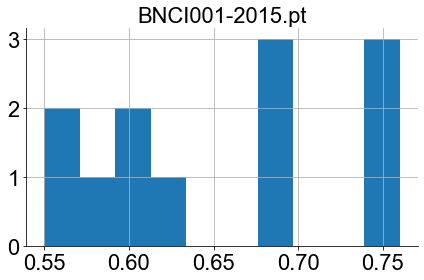

In [25]:
pd.DataFrame(R).to_csv(f'Cross_subject_validation_EEGNet_{targetDsName}.csv')
pd.DataFrame(R).hist('max_test_acc')
_ = plt.title(targetDsName)

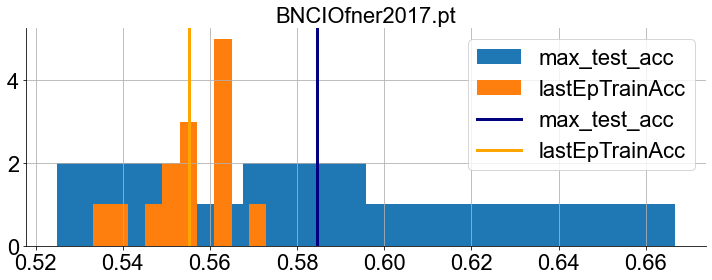

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

r = pd.DataFrame(R)
r.to_csv(f'Cross_subject_validation_EEGNet_{targetDsName}.csv')
r.hist('max_test_acc', ax=ax, label='max_test_acc')
r.hist('lastEpTrainAcc', ax=ax, label='lastEpTrainAcc')
ax.axvline(r.max_test_acc.mean(), color='navy', label='max_test_acc')
ax.axvline(r.lastEpTrainAcc.mean(), color='orange', label='lastEpTrainAcc')

plt.title(targetDsName)
plt.legend()

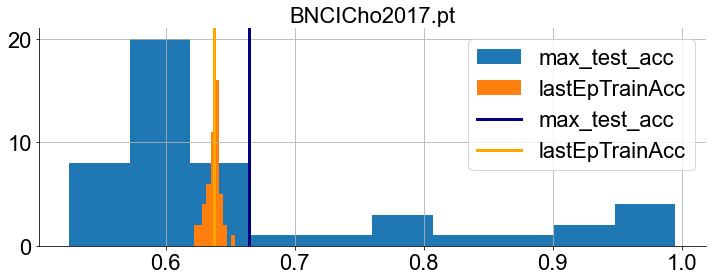

In [41]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

r = pd.DataFrame(R)
r.to_csv(f'Cross_subject_validation_EEGNet_{targetDsName}.csv')
r.hist('max_test_acc', ax=ax, label='max_test_acc')
r.hist('lastEpTrainAcc', ax=ax, label='lastEpTrainAcc')
ax.axvline(r.max_test_acc.mean(), color='navy', label='max_test_acc')
ax.axvline(r.lastEpTrainAcc.mean(), color='orange', label='lastEpTrainAcc')

plt.title(targetDsName)
plt.legend()

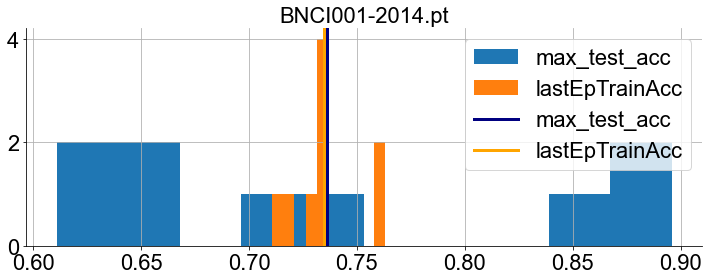

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

r = pd.DataFrame(R)
r.to_csv(f'Cross_subject_validation_EEGNet_{targetDsName}.csv')
r.hist('max_test_acc', ax=ax, label='max_test_acc')
r.hist('lastEpTrainAcc', ax=ax, label='lastEpTrainAcc')
ax.axvline(r.max_test_acc.mean(), color='navy', label='max_test_acc')
ax.axvline(r.lastEpTrainAcc.mean(), color='orange', label='lastEpTrainAcc')

plt.title(targetDsName)
plt.legend()

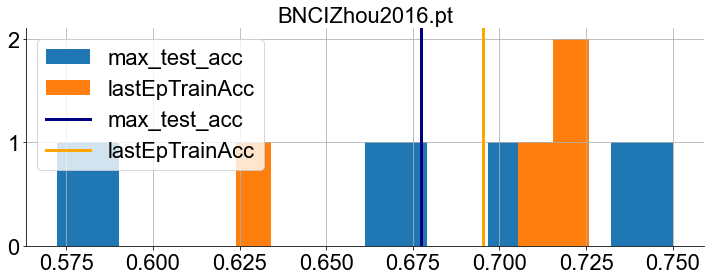

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

r = pd.DataFrame(R)
r.to_csv(f'Cross_subject_validation_EEGNet_{targetDsName}.csv')
r.hist('max_test_acc', ax=ax, label='max_test_acc')
r.hist('lastEpTrainAcc', ax=ax, label='lastEpTrainAcc')
ax.axvline(r.max_test_acc.mean(), color='navy', label='max_test_acc')
ax.axvline(r.lastEpTrainAcc.mean(), color='orange', label='lastEpTrainAcc')

plt.title(targetDsName)
plt.legend()

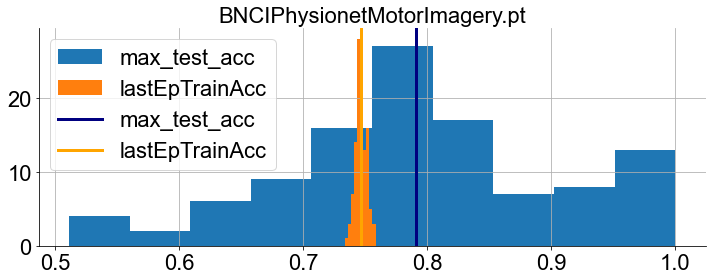

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

r = pd.DataFrame(R)
r.to_csv(f'Cross_subject_validation_EEGNet_{targetDsName}.csv')
r.hist('max_test_acc', ax=ax, label='max_test_acc')
r.hist('lastEpTrainAcc', ax=ax, label='lastEpTrainAcc')
ax.axvline(r.max_test_acc.mean(), color='navy', label='max_test_acc')
ax.axvline(r.lastEpTrainAcc.mean(), color='orange', label='lastEpTrainAcc')

plt.title(targetDsName)
plt.legend()